# Análisis de Hipótesis 2: Edad Creciente de Matrimonio

---

### Hipótesis

**"La edad promedio al contraer matrimonio ha aumentado consistentemente durante 2011-2021, reflejando cambios socioculturales hacia la postergación del matrimonio"**


## 1. Configuración Inicial y Carga de Librerías

In [43]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Librería para test de Mann-Kendall
try:
    import pymannkendall as mk
    MANNKENDALL_AVAILABLE = True
    print("✓ pymannkendall disponible")
except ImportError:
    MANNKENDALL_AVAILABLE = False
    print("pymannkendall no disponible. Se usará alternativa manual.")

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10


pymannkendall no disponible. Se usará alternativa manual.


## 2. Carga y Preparación de Datos

In [44]:
# Cargar dataset de matrimonios
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')
print(f"Matrimonios cargados: {matrimonios.shape[0]:,} registros, {matrimonios.shape[1]} variables")

Matrimonios cargados: 752,264 registros, 15 variables


### 2.1 Exploración Inicial de Variables de Edad

In [45]:
# Verificar disponibilidad de datos de edad
print("INFORMACIÓN DE VARIABLES DE EDAD")
print("="*80)

# Primero, verificar el tipo de datos y valores únicos
print("\nVerificación inicial de tipos de datos:")
print(f"  EDADHOM dtype: {matrimonios['EDADHOM'].dtype}")
print(f"  EDADMUJ dtype: {matrimonios['EDADMUJ'].dtype}")

# Verificar valores únicos en EDADHOM para identificar problemas
print(f"\nValores únicos en EDADHOM (primeros 20):")
print(f"  {matrimonios['EDADHOM'].unique()[:20]}")

# Convertir a numérico, reemplazando errores con NaN
matrimonios['EDADHOM'] = pd.to_numeric(matrimonios['EDADHOM'], errors='coerce')
matrimonios['EDADMUJ'] = pd.to_numeric(matrimonios['EDADMUJ'], errors='coerce')

print(f"\nDespués de conversión a numérico:")
print(f"  EDADHOM dtype: {matrimonios['EDADHOM'].dtype}")
print(f"  EDADMUJ dtype: {matrimonios['EDADMUJ'].dtype}")

# EDADHOM - Edad del hombre
print("\nEDADHOM (Edad del Hombre):")
print(f"  Total registros: {len(matrimonios)}")
print(f"  Valores válidos: {matrimonios['EDADHOM'].notna().sum()} ({(matrimonios['EDADHOM'].notna().sum()/len(matrimonios)*100):.2f}%)")
print(f"  Valores faltantes: {matrimonios['EDADHOM'].isna().sum()} ({(matrimonios['EDADHOM'].isna().sum()/len(matrimonios)*100):.2f}%)")
if matrimonios['EDADHOM'].notna().sum() > 0:
    print(f"  Rango: {matrimonios['EDADHOM'].min():.0f} - {matrimonios['EDADHOM'].max():.0f} años")
    print(f"  Media: {matrimonios['EDADHOM'].mean():.2f} años")
    print(f"  Mediana: {matrimonios['EDADHOM'].median():.0f} años")

# EDADMUJ - Edad de la mujer
print("\nEDADMUJ (Edad de la Mujer):")
print(f"  Total registros: {len(matrimonios)}")
print(f"  Valores válidos: {matrimonios['EDADMUJ'].notna().sum()} ({(matrimonios['EDADMUJ'].notna().sum()/len(matrimonios)*100):.2f}%)")
print(f"  Valores faltantes: {matrimonios['EDADMUJ'].isna().sum()} ({(matrimonios['EDADMUJ'].isna().sum()/len(matrimonios)*100):.2f}%)")
if matrimonios['EDADMUJ'].notna().sum() > 0:
    print(f"  Rango: {matrimonios['EDADMUJ'].min():.0f} - {matrimonios['EDADMUJ'].max():.0f} años")
    print(f"  Media: {matrimonios['EDADMUJ'].mean():.2f} años")
    print(f"  Mediana: {matrimonios['EDADMUJ'].median():.0f} años")

# Verificar valores extremos
print("\nVERIFICACIÓN DE VALORES ATÍPICOS:")
edad_hom_validos = matrimonios[matrimonios['EDADHOM'].between(15, 100)]
edad_muj_validos = matrimonios[matrimonios['EDADMUJ'].between(14, 100)]
print(f"  Hombres con edad válida (15-100): {len(edad_hom_validos):,}")
print(f"  Mujeres con edad válida (14-100): {len(edad_muj_validos):,}")

INFORMACIÓN DE VARIABLES DE EDAD

Verificación inicial de tipos de datos:
  EDADHOM dtype: object
  EDADMUJ dtype: object

Valores únicos en EDADHOM (primeros 20):
  ['27.0' '29.0' '21.0' '58.0' '31.0' '38.0' '32.0' '25.0' '44.0' '22.0'
 '37.0' '36.0' '33.0' '30.0' '28.0' '35.0' '39.0' '26.0' '43.0' '46.0']

Después de conversión a numérico:
  EDADHOM dtype: float64
  EDADMUJ dtype: float64

EDADHOM (Edad del Hombre):
  Total registros: 752264
  Valores válidos: 751969 (99.96%)
  Valores faltantes: 295 (0.04%)
  Rango: 12 - 99 años
  Media: 29.36 años
  Mediana: 26 años

EDADMUJ (Edad de la Mujer):
  Total registros: 752264
  Valores válidos: 751931 (99.96%)
  Valores faltantes: 333 (0.04%)
  Rango: 10 - 99 años
  Media: 26.37 años
  Mediana: 23 años

VERIFICACIÓN DE VALORES ATÍPICOS:
  Hombres con edad válida (15-100): 751,930
  Mujeres con edad válida (14-100): 751,645


### 2.2 Limpieza y Preparación de Datos

In [46]:
# Filtrar solo registros con edades válidas
# Consideramos edades razonables para matrimonio: 15-100 años
mat_clean = matrimonios[
    (matrimonios['EDADHOM'].notna()) & 
    (matrimonios['EDADMUJ'].notna()) &
    (matrimonios['EDADHOM'].between(15, 100)) &
    (matrimonios['EDADMUJ'].between(14, 100))
].copy()

print(f"Datos limpios: {len(mat_clean):,} registros ({(len(mat_clean)/len(matrimonios)*100):.2f}% del total)")
print(f"Registros excluidos: {len(matrimonios) - len(mat_clean):,}")

# Calcular edad promedio por pareja
mat_clean['EDAD_PROMEDIO'] = (mat_clean['EDADHOM'] + mat_clean['EDADMUJ']) / 2
mat_clean['DIFERENCIA_EDAD'] = mat_clean['EDADHOM'] - mat_clean['EDADMUJ']

#variables calculadas
#Promedio de edad entre ambos cónyuges
#Diferencia de edad (Hombre - Mujer)

Datos limpios: 751,419 registros (99.89% del total)
Registros excluidos: 845


## 3. Análisis de Tendencia Temporal

Analizamos cómo ha evolucionado la edad promedio de matrimonio a lo largo de los años.

### 3.1 Agregación por Año

In [47]:
# Agrupar por año y calcular estadísticas
tendencia_anual = mat_clean.groupby('AÑOREG').agg({
    'EDADHOM': ['mean', 'median', 'std', 'count'],
    'EDADMUJ': ['mean', 'median', 'std'],
    'EDAD_PROMEDIO': ['mean', 'median', 'std'],
    'DIFERENCIA_EDAD': ['mean', 'median']
}).reset_index()

# Aplanar nombres de columnas
tendencia_anual.columns = ['_'.join(col).strip('_') for col in tendencia_anual.columns.values]
tendencia_anual.rename(columns={'AÑOREG': 'Año'}, inplace=True)

# Renombrar para facilitar acceso
tendencia_anual.rename(columns={
    'EDADHOM_mean': 'Edad_Hombre_Media',
    'EDADHOM_median': 'Edad_Hombre_Mediana',
    'EDADHOM_std': 'Edad_Hombre_Std',
    'EDADHOM_count': 'N_Matrimonios',
    'EDADMUJ_mean': 'Edad_Mujer_Media',
    'EDADMUJ_median': 'Edad_Mujer_Mediana',
    'EDADMUJ_std': 'Edad_Mujer_Std',
    'EDAD_PROMEDIO_mean': 'Edad_Promedio_Media',
    'EDAD_PROMEDIO_median': 'Edad_Promedio_Mediana',
    'EDAD_PROMEDIO_std': 'Edad_Promedio_Std',
    'DIFERENCIA_EDAD_mean': 'Diferencia_Edad_Media',
    'DIFERENCIA_EDAD_median': 'Diferencia_Edad_Mediana'
}, inplace=True)

print("ESTADÍSTICAS ANUALES DE EDAD AL MATRIMONIO")
print("="*80)
print(tendencia_anual[['Año', 'N_Matrimonios', 'Edad_Hombre_Media', 'Edad_Mujer_Media', 
                        'Edad_Promedio_Media', 'Diferencia_Edad_Media']].to_string(index=False))

ESTADÍSTICAS ANUALES DE EDAD AL MATRIMONIO
   Año  N_Matrimonios  Edad_Hombre_Media  Edad_Mujer_Media  Edad_Promedio_Media  Diferencia_Edad_Media
2011.0          69825          28.225034         25.128879            26.676957               3.096155
2012.0          80719          28.810305         25.685254            27.247779               3.125051
2013.0          82456          28.726873         25.604820            27.165846               3.122053
2014.0          79900          28.966370         25.820901            27.393636               3.145469
2015.0          81483          28.778346         25.711216            27.244781               3.067131
2016.0          70384          30.146596         27.268243            28.707419               2.878353
2017.0          70827          30.016576         27.191339            28.603958               2.825236
2018.0          74952          30.165399         27.290186            28.727792               2.875213
2019.0          76146         

### 3.2 Cambio Total 2011-2021

In [48]:
# Comparar primer y último año disponibles
años_disponibles = sorted(tendencia_anual['Año'].unique())
año_inicial = años_disponibles[0]
año_final = años_disponibles[-1]

datos_inicial = tendencia_anual[tendencia_anual['Año'] == año_inicial].iloc[0]
datos_final = tendencia_anual[tendencia_anual['Año'] == año_final].iloc[0]

print(f"\nCAMBIO EN EL PERÍODO {año_inicial}-{año_final}")
print("="*80)

# Edad Hombres
cambio_hom = datos_final['Edad_Hombre_Media'] - datos_inicial['Edad_Hombre_Media']
cambio_hom_pct = (cambio_hom / datos_inicial['Edad_Hombre_Media']) * 100
print(f"\nEdad Hombres:")
print(f"  {año_inicial}: {datos_inicial['Edad_Hombre_Media']:.2f} años")
print(f"  {año_final}: {datos_final['Edad_Hombre_Media']:.2f} años")
print(f"  Cambio: {cambio_hom:+.2f} años ({cambio_hom_pct:+.2f}%)")

# Edad Mujeres
cambio_muj = datos_final['Edad_Mujer_Media'] - datos_inicial['Edad_Mujer_Media']
cambio_muj_pct = (cambio_muj / datos_inicial['Edad_Mujer_Media']) * 100
print(f"\nEdad Mujeres:")
print(f"  {año_inicial}: {datos_inicial['Edad_Mujer_Media']:.2f} años")
print(f"  {año_final}: {datos_final['Edad_Mujer_Media']:.2f} años")
print(f"  Cambio: {cambio_muj:+.2f} años ({cambio_muj_pct:+.2f}%)")

# Edad Promedio
cambio_prom = datos_final['Edad_Promedio_Media'] - datos_inicial['Edad_Promedio_Media']
cambio_prom_pct = (cambio_prom / datos_inicial['Edad_Promedio_Media']) * 100
print(f"\nEdad Promedio:")
print(f"  {año_inicial}: {datos_inicial['Edad_Promedio_Media']:.2f} años")
print(f"  {año_final}: {datos_final['Edad_Promedio_Media']:.2f} años")
print(f"  Cambio: {cambio_prom:+.2f} años ({cambio_prom_pct:+.2f}%)")

# Diferencia de edad
cambio_dif = datos_final['Diferencia_Edad_Media'] - datos_inicial['Diferencia_Edad_Media']
print(f"\nDiferencia de Edad (H-M):")
print(f"  {año_inicial}: {datos_inicial['Diferencia_Edad_Media']:.2f} años")
print(f"  {año_final}: {datos_final['Diferencia_Edad_Media']:.2f} años")
print(f"  Cambio: {cambio_dif:+.2f} años")


CAMBIO EN EL PERÍODO 2011.0-2021.0

Edad Hombres:
  2011.0: 28.23 años
  2021.0: 30.45 años
  Cambio: +2.23 años (+7.89%)

Edad Mujeres:
  2011.0: 25.13 años
  2021.0: 27.69 años
  Cambio: +2.56 años (+10.20%)

Edad Promedio:
  2011.0: 26.68 años
  2021.0: 29.07 años
  Cambio: +2.39 años (+8.97%)

Diferencia de Edad (H-M):
  2011.0: 3.10 años
  2021.0: 2.76 años
  Cambio: -0.34 años


### 3.3 Visualización de Tendencias

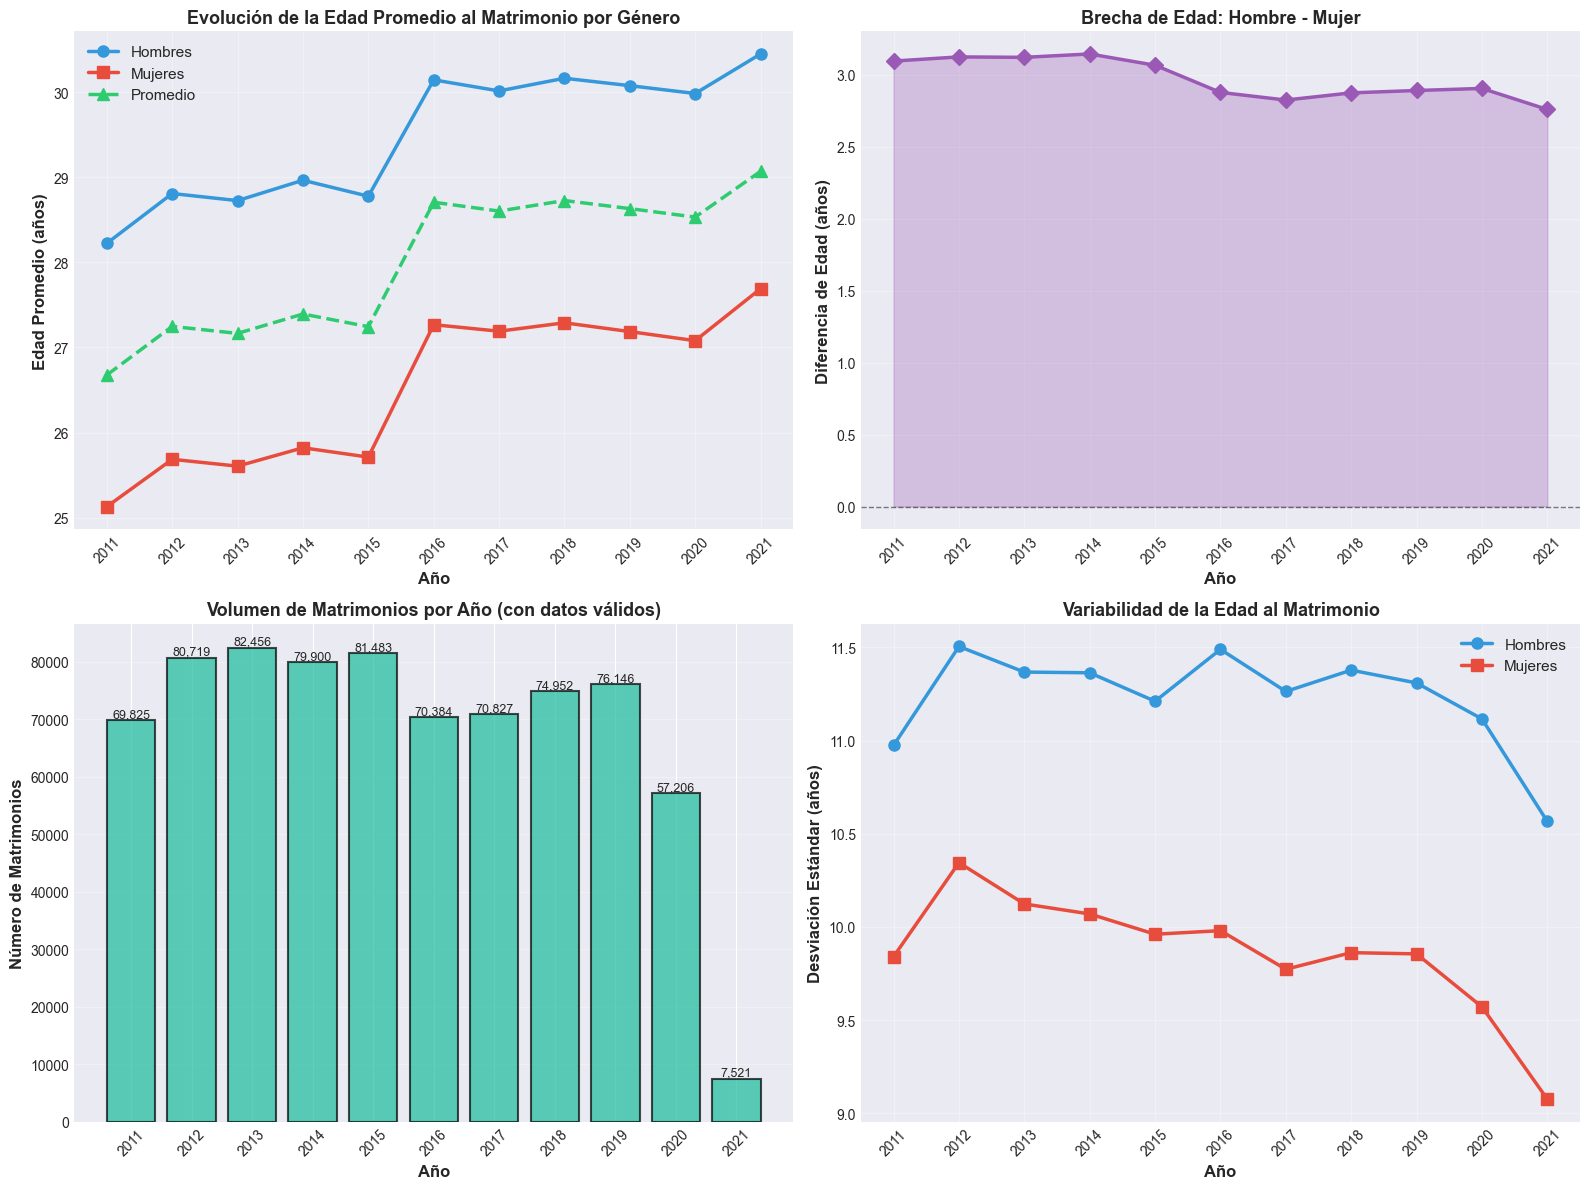

In [49]:
# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3.3.1 Evolución temporal por género
ax1 = axes[0, 0]
ax1.plot(tendencia_anual['Año'], tendencia_anual['Edad_Hombre_Media'], 
         marker='o', linewidth=2.5, markersize=8, color='#3498DB', label='Hombres')
ax1.plot(tendencia_anual['Año'], tendencia_anual['Edad_Mujer_Media'], 
         marker='s', linewidth=2.5, markersize=8, color='#E74C3C', label='Mujeres')
ax1.plot(tendencia_anual['Año'], tendencia_anual['Edad_Promedio_Media'], 
         marker='^', linewidth=2.5, markersize=8, color='#2ECC71', label='Promedio', linestyle='--')

ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Edad Promedio (años)', fontsize=12, fontweight='bold')
ax1.set_title('Evolución de la Edad Promedio al Matrimonio por Género', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(tendencia_anual['Año'])
ax1.tick_params(axis='x', rotation=45)

# 3.3.2 Diferencia de edad entre géneros
ax2 = axes[0, 1]
ax2.plot(tendencia_anual['Año'], tendencia_anual['Diferencia_Edad_Media'], 
         marker='D', linewidth=2.5, markersize=8, color='#9B59B6')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.fill_between(tendencia_anual['Año'], tendencia_anual['Diferencia_Edad_Media'], 
                 alpha=0.3, color='#9B59B6')

ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax2.set_title('Brecha de Edad: Hombre - Mujer', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(tendencia_anual['Año'])
ax2.tick_params(axis='x', rotation=45)

# 3.3.3 Número de matrimonios por año
ax3 = axes[1, 0]
bars = ax3.bar(tendencia_anual['Año'], tendencia_anual['N_Matrimonios'], 
               color='#1ABC9C', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Año', fontsize=12, fontweight='bold')
ax3.set_ylabel('Número de Matrimonios', fontsize=12, fontweight='bold')
ax3.set_title('Volumen de Matrimonios por Año (con datos válidos)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(tendencia_anual['Año'])
ax3.tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

# 3.3.4 Desviación estándar por género
ax4 = axes[1, 1]
ax4.plot(tendencia_anual['Año'], tendencia_anual['Edad_Hombre_Std'], 
         marker='o', linewidth=2.5, markersize=8, color='#3498DB', label='Hombres')
ax4.plot(tendencia_anual['Año'], tendencia_anual['Edad_Mujer_Std'], 
         marker='s', linewidth=2.5, markersize=8, color='#E74C3C', label='Mujeres')

ax4.set_xlabel('Año', fontsize=12, fontweight='bold')
ax4.set_ylabel('Desviación Estándar (años)', fontsize=12, fontweight='bold')
ax4.set_title('Variabilidad de la Edad al Matrimonio', fontsize=13, fontweight='bold')
ax4.legend(loc='best', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(tendencia_anual['Año'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Regresión Lineal: Modelando la Tendencia

Ajustamos modelos de regresión lineal para cuantificar la tendencia temporal.

### 4.1 Modelo de Regresión para Cada Género

In [50]:
# Preparar datos para regresión
X = tendencia_anual[['Año']].values
y_hombres = tendencia_anual['Edad_Hombre_Media'].values
y_mujeres = tendencia_anual['Edad_Mujer_Media'].values
y_promedio = tendencia_anual['Edad_Promedio_Media'].values

# Crear modelos de regresión
modelo_hombres = LinearRegression()
modelo_mujeres = LinearRegression()
modelo_promedio = LinearRegression()

# Entrenar modelos
modelo_hombres.fit(X, y_hombres)
modelo_mujeres.fit(X, y_mujeres)
modelo_promedio.fit(X, y_promedio)

# Predicciones
pred_hombres = modelo_hombres.predict(X)
pred_mujeres = modelo_mujeres.predict(X)
pred_promedio = modelo_promedio.predict(X)

# Métricas de ajuste
r2_hombres = r2_score(y_hombres, pred_hombres)
r2_mujeres = r2_score(y_mujeres, pred_mujeres)
r2_promedio = r2_score(y_promedio, pred_promedio)

rmse_hombres = np.sqrt(mean_squared_error(y_hombres, pred_hombres))
rmse_mujeres = np.sqrt(mean_squared_error(y_mujeres, pred_mujeres))
rmse_promedio = np.sqrt(mean_squared_error(y_promedio, pred_promedio))

print("RESULTADOS DE REGRESIÓN LINEAL")

print("\nHOMBRES:")
print(f"  Ecuación: Edad = {modelo_hombres.intercept_:.4f} + {modelo_hombres.coef_[0]:.4f} × Año")
print(f"  R² (ajuste): {r2_hombres:.4f}")
print(f"  RMSE: {rmse_hombres:.4f} años")
print(f"  Pendiente: {modelo_hombres.coef_[0]:.4f} años/año")
print(f"  → La edad aumenta {modelo_hombres.coef_[0]:.4f} años por cada año transcurrido")

print("\nMUJERES:")
print(f"  Ecuación: Edad = {modelo_mujeres.intercept_:.4f} + {modelo_mujeres.coef_[0]:.4f} × Año")
print(f"  R² (ajuste): {r2_mujeres:.4f}")
print(f"  RMSE: {rmse_mujeres:.4f} años")
print(f"  Pendiente: {modelo_mujeres.coef_[0]:.4f} años/año")
print(f"  → La edad aumenta {modelo_mujeres.coef_[0]:.4f} años por cada año transcurrido")

print("\nPROMEDIO:")
print(f"  Ecuación: Edad = {modelo_promedio.intercept_:.4f} + {modelo_promedio.coef_[0]:.4f} × Año")
print(f"  R² (ajuste): {r2_promedio:.4f}")
print(f"  RMSE: {rmse_promedio:.4f} años")
print(f"  Pendiente: {modelo_promedio.coef_[0]:.4f} años/año")
print(f"  → La edad aumenta {modelo_promedio.coef_[0]:.4f} años por cada año transcurrido")

RESULTADOS DE REGRESIÓN LINEAL

HOMBRES:
  Ecuación: Edad = -401.6688 + 0.2139 × Año
  R² (ajuste): 0.8240
  RMSE: 0.3126 años
  Pendiente: 0.2139 años/año
  → La edad aumenta 0.2139 años por cada año transcurrido

MUJERES:
  Ecuación: Edad = -478.5178 + 0.2505 × Año
  R² (ajuste): 0.8271
  RMSE: 0.3622 años
  Pendiente: 0.2505 años/año
  → La edad aumenta 0.2505 años por cada año transcurrido

PROMEDIO:
  Ecuación: Edad = -440.0933 + 0.2322 × Año
  R² (ajuste): 0.8263
  RMSE: 0.3367 años
  Pendiente: 0.2322 años/año
  → La edad aumenta 0.2322 años por cada año transcurrido


### 4.2 Interpretación de las Pendientes

In [51]:
# Análisis de las pendientes
n_años = año_final - año_inicial
aumento_total_hombres = modelo_hombres.coef_[0] * n_años
aumento_total_mujeres = modelo_mujeres.coef_[0] * n_años
aumento_total_promedio = modelo_promedio.coef_[0] * n_años

print("\nNTERPRETACIÓN DE TENDENCIAS")
print(f"\nPeríodo analizado: {año_inicial}-{año_final} ({n_años} años)")
print(f"\nAumento total estimado por regresión:")
print(f"  Hombres: {aumento_total_hombres:+.2f} años")
print(f"  Mujeres: {aumento_total_mujeres:+.2f} años")
print(f"  Promedio: {aumento_total_promedio:+.2f} años")

# Determinar si la tendencia es significativa
print("\nEVALUACIÓN DE TENDENCIAS:")
for nombre, coef, r2 in [('Hombres', modelo_hombres.coef_[0], r2_hombres),
                          ('Mujeres', modelo_mujeres.coef_[0], r2_mujeres),
                          ('Promedio', modelo_promedio.coef_[0], r2_promedio)]:
    if coef > 0.05:
        tendencia = "CRECIENTE"
    elif coef < -0.05:
        tendencia = "DECRECIENTE"
    else:
        tendencia = "ESTABLE"
    
    if r2 > 0.8:
        calidad = "excelente"
    elif r2 > 0.6:
        calidad = "buena"
    elif r2 > 0.4:
        calidad = "moderada"
    else:
        calidad = "débil"
    
    print(f" {nombre}: Tendencia {tendencia} con ajuste {calidad} (R²={r2:.3f})")


NTERPRETACIÓN DE TENDENCIAS

Período analizado: 2011.0-2021.0 (10.0 años)

Aumento total estimado por regresión:
  Hombres: +2.14 años
  Mujeres: +2.51 años
  Promedio: +2.32 años

EVALUACIÓN DE TENDENCIAS:
 Hombres: Tendencia CRECIENTE con ajuste excelente (R²=0.824)
 Mujeres: Tendencia CRECIENTE con ajuste excelente (R²=0.827)
 Promedio: Tendencia CRECIENTE con ajuste excelente (R²=0.826)


### 4.3 Visualización de Regresiones

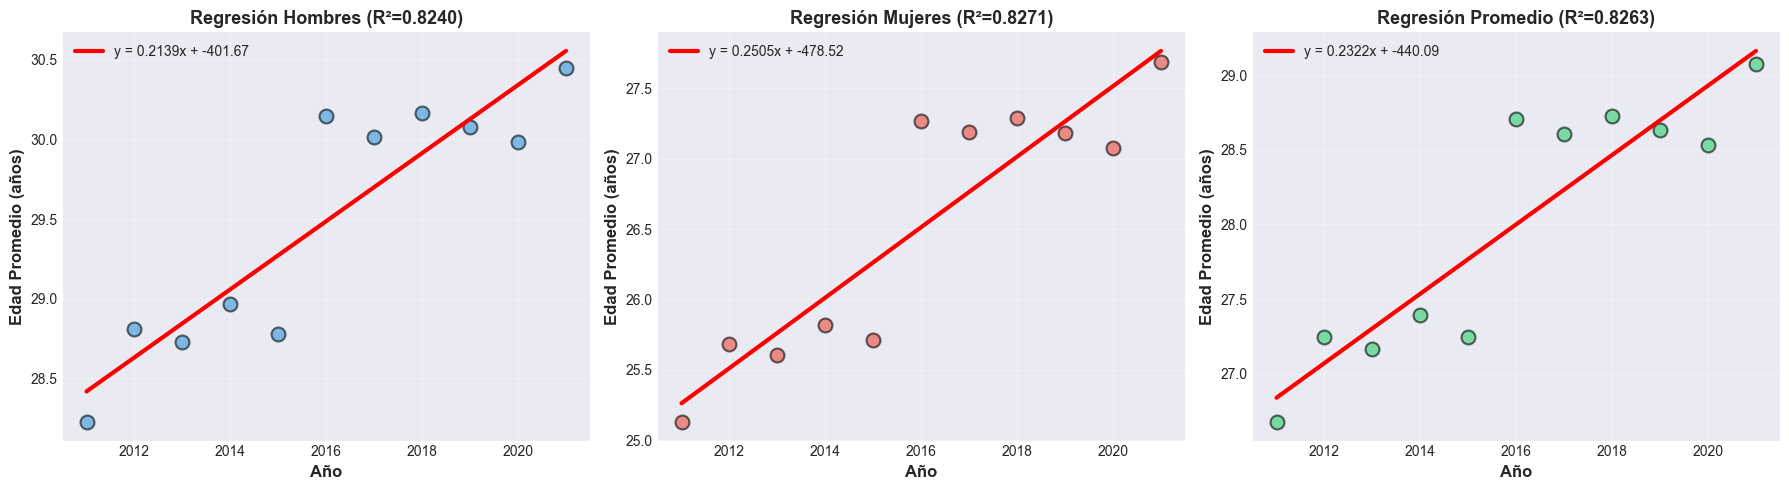

✓ Gráficos de regresión generados


In [52]:
# Visualización de las regresiones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 4.3.1 Regresión Hombres
ax1 = axes[0]
ax1.scatter(X, y_hombres, s=100, alpha=0.6, color='#3498DB', edgecolors='black', linewidth=1.5)
ax1.plot(X, pred_hombres, 'r-', linewidth=3, label=f'y = {modelo_hombres.coef_[0]:.4f}x + {modelo_hombres.intercept_:.2f}')
ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Edad Promedio (años)', fontsize=12, fontweight='bold')
ax1.set_title(f'Regresión Hombres (R²={r2_hombres:.4f})', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 4.3.2 Regresión Mujeres
ax2 = axes[1]
ax2.scatter(X, y_mujeres, s=100, alpha=0.6, color='#E74C3C', edgecolors='black', linewidth=1.5)
ax2.plot(X, pred_mujeres, 'r-', linewidth=3, label=f'y = {modelo_mujeres.coef_[0]:.4f}x + {modelo_mujeres.intercept_:.2f}')
ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Edad Promedio (años)', fontsize=12, fontweight='bold')
ax2.set_title(f'Regresión Mujeres (R²={r2_mujeres:.4f})', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# 4.3.3 Regresión Promedio
ax3 = axes[2]
ax3.scatter(X, y_promedio, s=100, alpha=0.6, color='#2ECC71', edgecolors='black', linewidth=1.5)
ax3.plot(X, pred_promedio, 'r-', linewidth=3, label=f'y = {modelo_promedio.coef_[0]:.4f}x + {modelo_promedio.intercept_:.2f}')
ax3.set_xlabel('Año', fontsize=12, fontweight='bold')
ax3.set_ylabel('Edad Promedio (años)', fontsize=12, fontweight='bold')
ax3.set_title(f'Regresión Promedio (R²={r2_promedio:.4f})', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Gráficos de regresión generados")

## 5. Test de Mann-Kendall

Aplicamos el test de Mann-Kendall para validar estadísticamente la existencia de una tendencia monotónica.

In [53]:
def mann_kendall_test_manual(data):
    """
    Implementación manual del test de Mann-Kendall
    Retorna: tau (estadístico), p_value (valor p), tendencia (texto)
    """
    n = len(data)
    
    # Calcular S
    s = 0
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign(data[j] - data[i])
    
    # Calcular varianza de S
    var_s = n * (n - 1) * (2*n + 5) / 18
    
    # Calcular estadístico Z
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # Calcular p-value (bilateral)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    # Calcular Tau de Kendall
    tau = s / (0.5 * n * (n - 1))
    
    # Determinar tendencia
    if p_value < 0.05:
        if z > 0:
            tendencia = "Tendencia creciente significativa"
        else:
            tendencia = "Tendencia decreciente significativa"
    else:
        tendencia = "Sin tendencia significativa"
    
    return tau, z, p_value, tendencia

print("TEST DE MANN-KENDALL")
print("\nEl test de Mann-Kendall evalúa si existe una tendencia monotónica en una serie temporal sin asumir linealidad.")
print("\nH₀: No existe tendencia")
print("H₁: Existe tendencia (creciente o decreciente)")
print("\nNivel de significancia: α = 0.05")

TEST DE MANN-KENDALL

El test de Mann-Kendall evalúa si existe una tendencia monotónica en una serie temporal sin asumir linealidad.

H₀: No existe tendencia
H₁: Existe tendencia (creciente o decreciente)

Nivel de significancia: α = 0.05


### 5.1 Test para Edad de Hombres

In [54]:
# Test para Hombres
if MANNKENDALL_AVAILABLE:
    mk_result_hom = mk.original_test(y_hombres)
    print("\nHOMBRES (usando pymannkendall):")
    print(f"  Tendencia: {mk_result_hom.trend}")
    print(f"  Tau de Kendall: {mk_result_hom.tau:.4f}")
    print(f"  p-value: {mk_result_hom.p:.6f}")
    print(f"  Estadístico z: {mk_result_hom.z:.4f}")
else:
    tau_hom, z_hom, p_hom, tend_hom = mann_kendall_test_manual(y_hombres)
    print("\nHOMBRES (implementación manual):")
    print(f"  Tendencia: {tend_hom}")
    print(f"  Tau de Kendall: {tau_hom:.4f}")
    print(f"  p-value: {p_hom:.6f}")
    print(f"  Estadístico z: {z_hom:.4f}")

# Interpretación
p_val_hom = mk_result_hom.p if MANNKENDALL_AVAILABLE else p_hom
if p_val_hom < 0.05:
    print("\nSe RECHAZA H₀: Existe evidencia estadística de tendencia")
    print(f"    La edad de matrimonio de los hombres muestra una tendencia significativa.")
else:
    print("\nNo se rechaza H₀: No hay evidencia suficiente de tendencia")
    print(f"    La edad de matrimonio de los hombres no muestra tendencia significativa.")


HOMBRES (implementación manual):
  Tendencia: Tendencia creciente significativa
  Tau de Kendall: 0.6364
  p-value: 0.008123
  Estadístico z: 2.6469

Se RECHAZA H₀: Existe evidencia estadística de tendencia
    La edad de matrimonio de los hombres muestra una tendencia significativa.


### 5.2 Test para Edad de Mujeres

In [55]:
# Test para Mujeres
if MANNKENDALL_AVAILABLE:
    mk_result_muj = mk.original_test(y_mujeres)
    print("\nMUJERES (usando pymannkendall):")
    print(f"  Tendencia: {mk_result_muj.trend}")
    print(f"  Tau de Kendall: {mk_result_muj.tau:.4f}")
    print(f"  p-value: {mk_result_muj.p:.6f}")
    print(f"  Estadístico z: {mk_result_muj.z:.4f}")
else:
    tau_muj, z_muj, p_muj, tend_muj = mann_kendall_test_manual(y_mujeres)
    print("\nMUJERES (implementación manual):")
    print(f"  Tendencia: {tend_muj}")
    print(f"  Tau de Kendall: {tau_muj:.4f}")
    print(f"  p-value: {p_muj:.6f}")
    print(f"  Estadístico z: {z_muj:.4f}")

# Interpretación
p_val_muj = mk_result_muj.p if MANNKENDALL_AVAILABLE else p_muj
if p_val_muj < 0.05:
    print("\n Se RECHAZA H₀: Existe evidencia estadística de tendencia")
    print(f"    La edad de matrimonio de las mujeres muestra una tendencia significativa.")
else:
    print("\nNo se rechaza H₀: No hay evidencia suficiente de tendencia")
    print(f"    La edad de matrimonio de las mujeres no muestra tendencia significativa.")


MUJERES (implementación manual):
  Tendencia: Tendencia creciente significativa
  Tau de Kendall: 0.6364
  p-value: 0.008123
  Estadístico z: 2.6469

 Se RECHAZA H₀: Existe evidencia estadística de tendencia
    La edad de matrimonio de las mujeres muestra una tendencia significativa.


## 6. Comparación Estadística 2011 vs 2021

Realizamos pruebas de hipótesis para comparar las distribuciones de edad en el primer y último año.

In [56]:
# Extraer datos de años específicos
datos_2011 = mat_clean[mat_clean['AÑOREG'] == año_inicial]
datos_2021 = mat_clean[mat_clean['AÑOREG'] == año_final]

print(f"\nCOMPARACIÓN {año_inicial} vs {año_final}")
print(f"\nRegistros {año_inicial}: {len(datos_2011):,}")
print(f"Registros {año_final}: {len(datos_2021):,}")


COMPARACIÓN 2011.0 vs 2021.0

Registros 2011.0: 69,825
Registros 2021.0: 7,521


### 6.1 Test de Mann-Whitney U (no paramétrico)

In [57]:
# Test de Mann-Whitney U para Hombres
stat_hom, p_hom_mw = mannwhitneyu(datos_2011['EDADHOM'], datos_2021['EDADHOM'], alternative='two-sided')
print("\nHOMBRES - Test de Mann-Whitney U:")
print("="*80)
print(f"  Estadístico U: {stat_hom:.2f}")
print(f"  p-value: {p_hom_mw:.6f}")
if p_hom_mw < 0.05:
    print(f"  ✓ Las distribuciones son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
    med_diff = datos_2021['EDADHOM'].median() - datos_2011['EDADHOM'].median()
    print(f"  Diferencia de medianas: {med_diff:+.2f} años")
else:
    print(f"  ✗ No hay diferencia significativa entre las distribuciones")

# Test de Mann-Whitney U para Mujeres
stat_muj, p_muj_mw = mannwhitneyu(datos_2011['EDADMUJ'], datos_2021['EDADMUJ'], alternative='two-sided')
print("\nMUJERES - Test de Mann-Whitney U:")
print("="*80)
print(f"  Estadístico U: {stat_muj:.2f}")
print(f"  p-value: {p_muj_mw:.6f}")
if p_muj_mw < 0.05:
    print(f"Las distribuciones son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
    med_diff = datos_2021['EDADMUJ'].median() - datos_2011['EDADMUJ'].median()
    print(f"Diferencia de medianas: {med_diff:+.2f} años")
else:
    print(f"No hay diferencia significativa entre las distribuciones")


HOMBRES - Test de Mann-Whitney U:
  Estadístico U: 209455232.00
  p-value: 0.000000
  ✓ Las distribuciones son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)
  Diferencia de medianas: +3.00 años

MUJERES - Test de Mann-Whitney U:
  Estadístico U: 195282386.50
  p-value: 0.000000
Las distribuciones son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)
Diferencia de medianas: +3.00 años


### 6.2 Visualización de Distribuciones

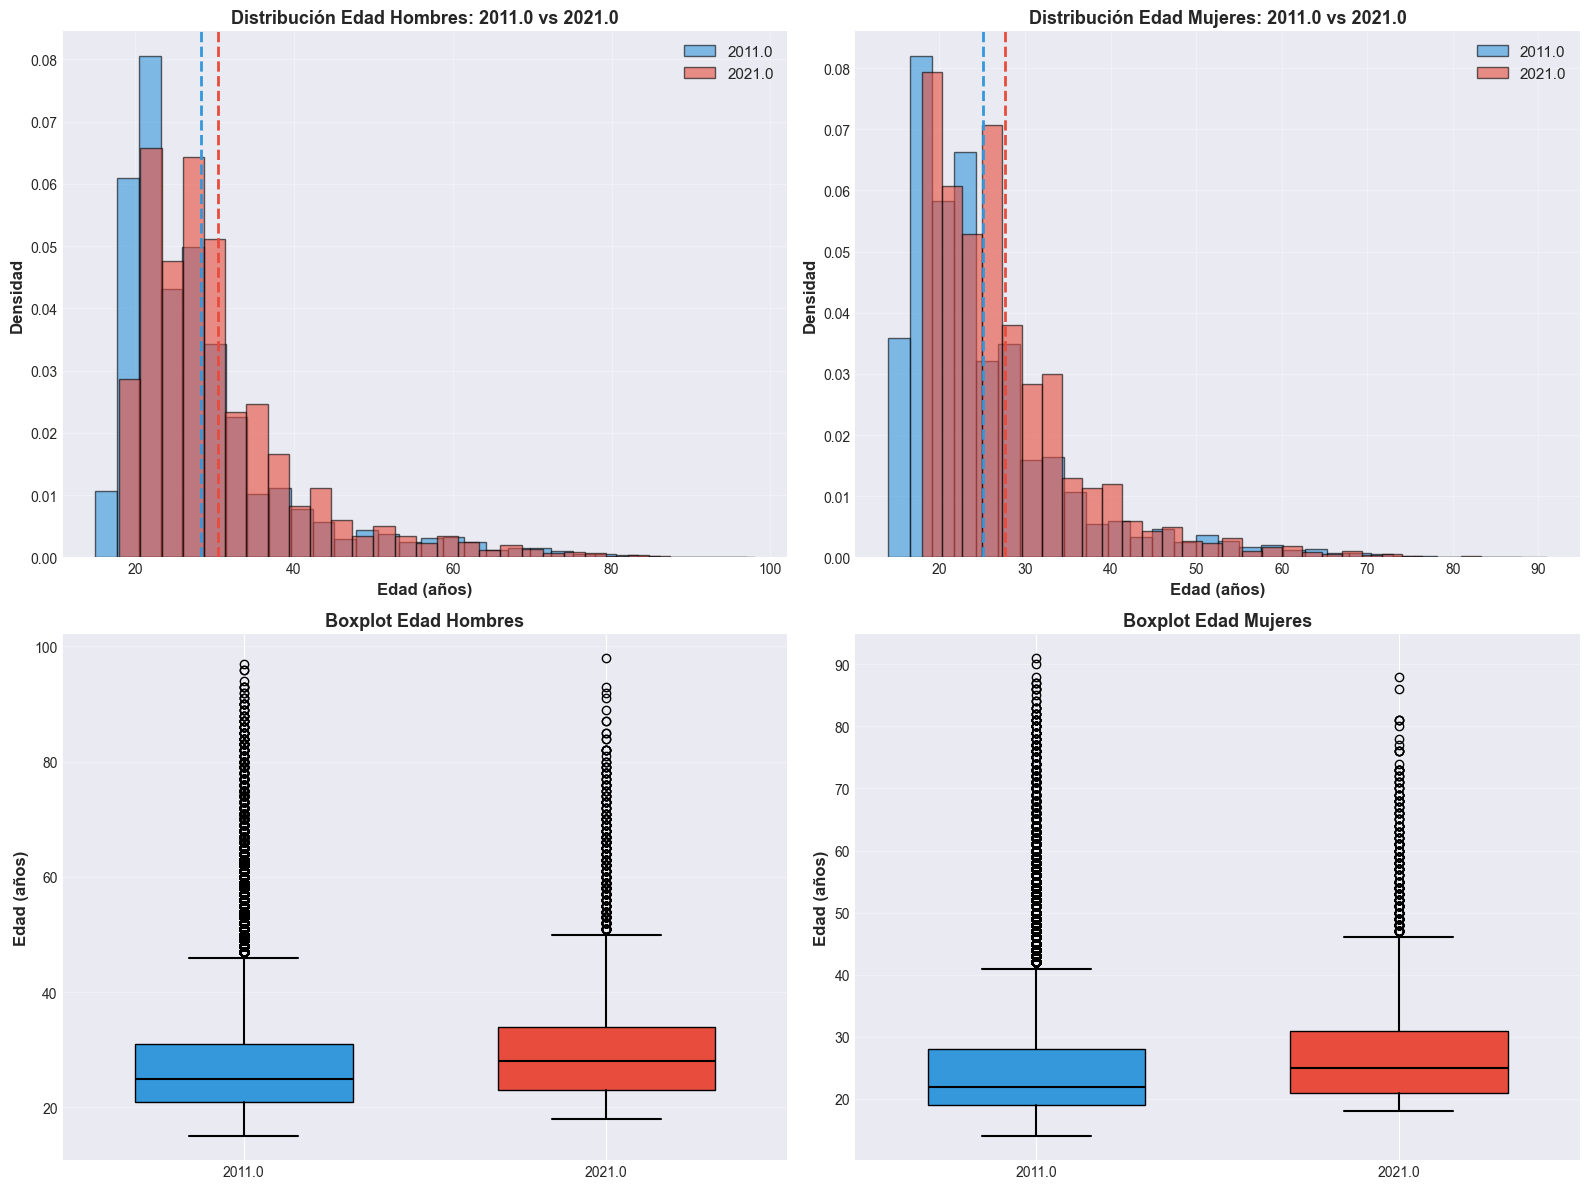

In [58]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 6.3.1 Histogramas Hombres
ax1 = axes[0, 0]
ax1.hist(datos_2011['EDADHOM'], bins=30, alpha=0.6, color='#3498DB', 
         label=f'{año_inicial}', edgecolor='black', density=True)
ax1.hist(datos_2021['EDADHOM'], bins=30, alpha=0.6, color='#E74C3C', 
         label=f'{año_final}', edgecolor='black', density=True)
ax1.axvline(datos_2011['EDADHOM'].mean(), color='#3498DB', linestyle='--', linewidth=2)
ax1.axvline(datos_2021['EDADHOM'].mean(), color='#E74C3C', linestyle='--', linewidth=2)
ax1.set_xlabel('Edad (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax1.set_title(f'Distribución Edad Hombres: {año_inicial} vs {año_final}', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# 6.3.2 Histogramas Mujeres
ax2 = axes[0, 1]
ax2.hist(datos_2011['EDADMUJ'], bins=30, alpha=0.6, color='#3498DB', 
         label=f'{año_inicial}', edgecolor='black', density=True)
ax2.hist(datos_2021['EDADMUJ'], bins=30, alpha=0.6, color='#E74C3C', 
         label=f'{año_final}', edgecolor='black', density=True)
ax2.axvline(datos_2011['EDADMUJ'].mean(), color='#3498DB', linestyle='--', linewidth=2)
ax2.axvline(datos_2021['EDADMUJ'].mean(), color='#E74C3C', linestyle='--', linewidth=2)
ax2.set_xlabel('Edad (años)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribución Edad Mujeres: {año_inicial} vs {año_final}', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

# 6.3.3 Boxplots Hombres
ax3 = axes[1, 0]
bp_hom = ax3.boxplot([datos_2011['EDADHOM'], datos_2021['EDADHOM']], 
                      labels=[f'{año_inicial}', f'{año_final}'],
                      patch_artist=True, widths=0.6)
bp_hom['boxes'][0].set_facecolor('#3498DB')
bp_hom['boxes'][1].set_facecolor('#E74C3C')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp_hom[element], color='black', linewidth=1.5)
ax3.set_ylabel('Edad (años)', fontsize=12, fontweight='bold')
ax3.set_title('Boxplot Edad Hombres', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 6.3.4 Boxplots Mujeres
ax4 = axes[1, 1]
bp_muj = ax4.boxplot([datos_2011['EDADMUJ'], datos_2021['EDADMUJ']], 
                      labels=[f'{año_inicial}', f'{año_final}'],
                      patch_artist=True, widths=0.6)
bp_muj['boxes'][0].set_facecolor('#3498DB')
bp_muj['boxes'][1].set_facecolor('#E74C3C')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp_muj[element], color='black', linewidth=1.5)
ax4.set_ylabel('Edad (años)', fontsize=12, fontweight='bold')
ax4.set_title('Boxplot Edad Mujeres', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Clustering Temporal

Agrupamos los años según su comportamiento en edad de matrimonio.

### 7.1 Preparación de Datos para Clustering

In [59]:
# Preparar features para clustering
features_clustering = tendencia_anual[[
    'Edad_Hombre_Media', 'Edad_Mujer_Media', 
    'Edad_Promedio_Media', 'Diferencia_Edad_Media'
]].values

# Normalizar
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clustering)

print("Datos preparados para clustering:")
print(f"   - Dimensiones: {features_scaled.shape}")
print(f"   - Features: Edad_Hombre, Edad_Mujer, Edad_Promedio, Diferencia_Edad")

Datos preparados para clustering:
   - Dimensiones: (11, 4)
   - Features: Edad_Hombre, Edad_Mujer, Edad_Promedio, Diferencia_Edad


### 7.2 Determinación del Número Óptimo de Clusters

In [60]:
# Método del codo y silhouette
inertias = []
silhouette_scores = []
K_range = range(2, min(6, len(tendencia_anual)))  # Limitar K según datos disponibles

print("Evaluando diferentes números de clusters...")
print(f"{'K':<5} {'Inercia':<15} {'Silhouette':<15} {'Interpretación'}")
print("="*80)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg > 0.7:
        interpretacion = "Excelente"
    elif silhouette_avg > 0.5:
        interpretacion = "Buena"
    elif silhouette_avg > 0.3:
        interpretacion = "Aceptable"
    else:
        interpretacion = "Pobre"
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {silhouette_avg:<15.4f} {interpretacion}")

# Determinar mejor K
best_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print("\n" + "="*80)
print(f"✓ MEJOR NÚMERO DE CLUSTERS: K = {best_k}")
print(f"  Silhouette Score: {best_silhouette:.4f}")
print("="*80)

Evaluando diferentes números de clusters...
K     Inercia         Silhouette      Interpretación
2     3.28            0.8185          Excelente
3     1.95            0.6815          Buena
4     0.65            0.5617          Buena
5     0.46            0.4152          Aceptable

✓ MEJOR NÚMERO DE CLUSTERS: K = 2
  Silhouette Score: 0.8185


### 7.3 Aplicar Clustering y Análisis

In [61]:
# Aplicar clustering con mejor K
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
tendencia_anual['Cluster'] = kmeans_final.fit_predict(features_scaled)

print(f"Clustering completado con {best_k} clusters")
print(f"\nDistribución de años por cluster:")
for cluster_id in range(best_k):
    años_cluster = tendencia_anual[tendencia_anual['Cluster'] == cluster_id]['Año'].tolist()
    print(f"  Cluster {cluster_id}: {años_cluster}")

Clustering completado con 2 clusters

Distribución de años por cluster:
  Cluster 0: [2011.0, 2012.0, 2013.0, 2014.0, 2015.0]
  Cluster 1: [2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0]


### 7.4 Interpretación de Clusters Temporales

In [62]:
# Análisis de clusters
print("\nCARACTERÍSTICAS DE LOS CLUSTERS TEMPORALES")
print("="*80)

for cluster_id in range(best_k):
    cluster_data = tendencia_anual[tendencia_anual['Cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}")
    print("="*80)
    print(f"Años: {', '.join(map(str, cluster_data['Año'].tolist()))}")
    print(f"\nCaracterísticas:")
    print(f"  Edad Hombre (promedio): {cluster_data['Edad_Hombre_Media'].mean():.2f} años")
    print(f"  Edad Mujer (promedio): {cluster_data['Edad_Mujer_Media'].mean():.2f} años")
    print(f"  Edad Promedio general: {cluster_data['Edad_Promedio_Media'].mean():.2f} años")
    print(f"  Diferencia de edad: {cluster_data['Diferencia_Edad_Media'].mean():.2f} años")
    print(f"  Número de matrimonios: {cluster_data['N_Matrimonios'].sum():,}")


CARACTERÍSTICAS DE LOS CLUSTERS TEMPORALES

CLUSTER 0
Años: 2011.0, 2012.0, 2013.0, 2014.0, 2015.0

Características:
  Edad Hombre (promedio): 28.70 años
  Edad Mujer (promedio): 25.59 años
  Edad Promedio general: 27.15 años
  Diferencia de edad: 3.11 años
  Número de matrimonios: 394,383

CLUSTER 1
Años: 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0

Características:
  Edad Hombre (promedio): 30.14 años
  Edad Mujer (promedio): 27.28 años
  Edad Promedio general: 28.71 años
  Diferencia de edad: 2.86 años
  Número de matrimonios: 357,036


### 7.5 Visualización de Clusters

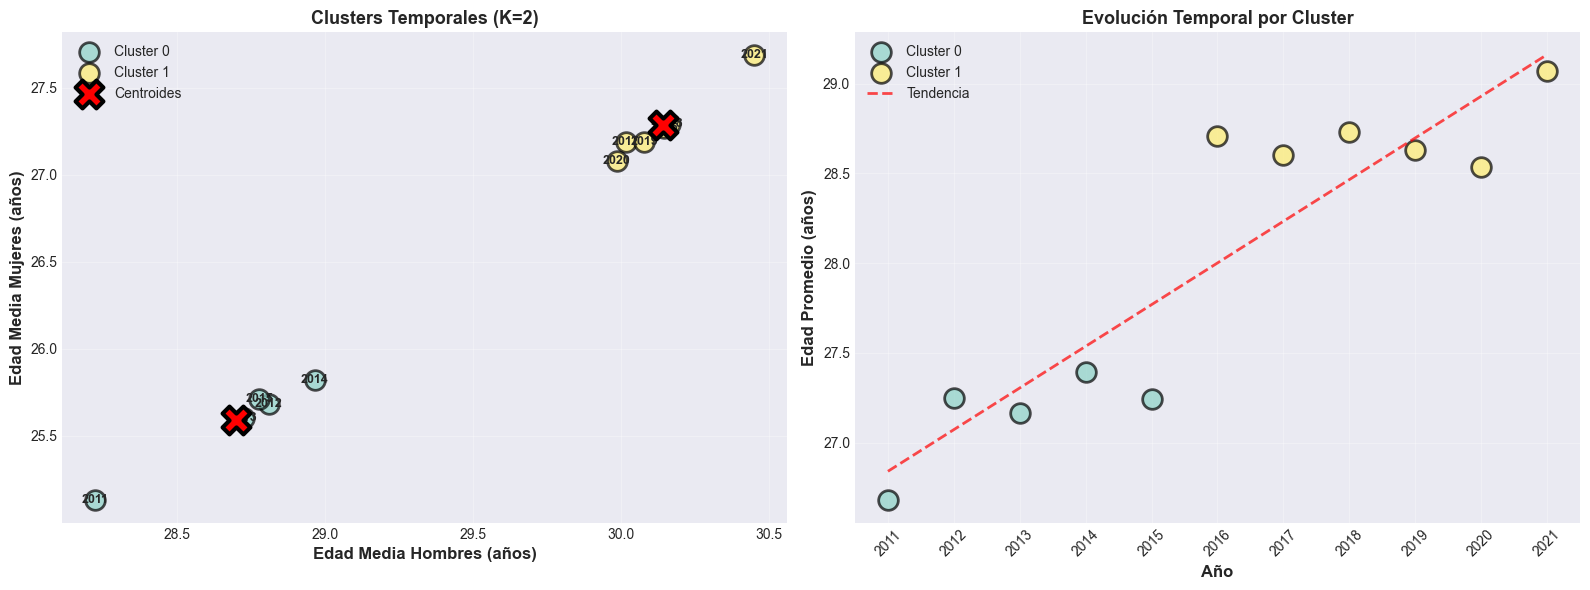

In [63]:
# Visualización de clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 7.5.1 Scatter plot 2D (Edad Hombre vs Mujer)
ax1 = axes[0]
colors = plt.cm.Set3(np.linspace(0, 1, best_k))
for cluster_id in range(best_k):
    cluster_data = tendencia_anual[tendencia_anual['Cluster'] == cluster_id]
    ax1.scatter(cluster_data['Edad_Hombre_Media'], cluster_data['Edad_Mujer_Media'],
               s=200, alpha=0.7, color=colors[cluster_id], 
               edgecolors='black', linewidth=2, label=f'Cluster {cluster_id}')
    
    # Añadir etiquetas de año
    for _, row in cluster_data.iterrows():
        ax1.annotate(int(row['Año']), 
                    (row['Edad_Hombre_Media'], row['Edad_Mujer_Media']),
                    fontsize=9, ha='center', va='center', fontweight='bold')

# Añadir centroides
centroides = scaler.inverse_transform(kmeans_final.cluster_centers_)
ax1.scatter(centroides[:, 0], centroides[:, 1], 
           s=400, marker='X', c='red', edgecolors='black', 
           linewidth=3, label='Centroides', zorder=10)

ax1.set_xlabel('Edad Media Hombres (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Edad Media Mujeres (años)', fontsize=12, fontweight='bold')
ax1.set_title(f'Clusters Temporales (K={best_k})', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 7.5.2 Línea temporal con clusters
ax2 = axes[1]
for cluster_id in range(best_k):
    cluster_data = tendencia_anual[tendencia_anual['Cluster'] == cluster_id]
    ax2.scatter(cluster_data['Año'], cluster_data['Edad_Promedio_Media'],
               s=200, alpha=0.7, color=colors[cluster_id],
               edgecolors='black', linewidth=2, label=f'Cluster {cluster_id}')

# Línea de tendencia general
ax2.plot(tendencia_anual['Año'], pred_promedio, 
        'r--', linewidth=2, alpha=0.7, label='Tendencia')

ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Edad Promedio (años)', fontsize=12, fontweight='bold')
ax2.set_title('Evolución Temporal por Cluster', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(tendencia_anual['Año'])
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Validación de Hipótesis

Evaluamos la hipótesis usando múltiples criterios.

### 8.1 Criterio 1: Pendiente Positiva en Regresión

In [64]:
print("\n1. REGRESIÓN LINEAL - PENDIENTE:")
print("-" * 80)

# Evaluar hombres
if modelo_hombres.coef_[0] > 0 and r2_hombres > 0.6:
    print(f"  ✓ Hombres: Pendiente positiva ({modelo_hombres.coef_[0]:.4f}) con buen ajuste (R²={r2_hombres:.4f})")
    validacion_1a = True
else:
    print(f"  ✗ Hombres: Pendiente={modelo_hombres.coef_[0]:.4f}, R²={r2_hombres:.4f}")
    validacion_1a = False

# Evaluar mujeres
if modelo_mujeres.coef_[0] > 0 and r2_mujeres > 0.6:
    print(f"  ✓ Mujeres: Pendiente positiva ({modelo_mujeres.coef_[0]:.4f}) con buen ajuste (R²={r2_mujeres:.4f})")
    validacion_1b = True
else:
    print(f"  ✗ Mujeres: Pendiente={modelo_mujeres.coef_[0]:.4f}, R²={r2_mujeres:.4f}")
    validacion_1b = False

# Evaluar promedio
if modelo_promedio.coef_[0] > 0 and r2_promedio > 0.6:
    print(f"  ✓ Promedio: Pendiente positiva ({modelo_promedio.coef_[0]:.4f}) con buen ajuste (R²={r2_promedio:.4f})")
    validacion_1c = True
else:
    print(f"  ✗ Promedio: Pendiente={modelo_promedio.coef_[0]:.4f}, R²={r2_promedio:.4f}")
    validacion_1c = False

validacion_1 = validacion_1a and validacion_1b and validacion_1c


1. REGRESIÓN LINEAL - PENDIENTE:
--------------------------------------------------------------------------------
  ✓ Hombres: Pendiente positiva (0.2139) con buen ajuste (R²=0.8240)
  ✓ Mujeres: Pendiente positiva (0.2505) con buen ajuste (R²=0.8271)
  ✓ Promedio: Pendiente positiva (0.2322) con buen ajuste (R²=0.8263)


### 8.2 Criterio 2: Test de Mann-Kendall Significativo

In [65]:
print("\n2. TEST DE MANN-KENDALL - TENDENCIA SIGNIFICATIVA:")
print("-" * 80)

if p_val_hom < 0.05:
    print(f"  ✓ Hombres: Tendencia significativa (p={p_val_hom:.4f})")
    validacion_2a = True
else:
    print(f"  ✗ Hombres: Sin tendencia significativa (p={p_val_hom:.4f})")
    validacion_2a = False

if p_val_muj < 0.05:
    print(f"  ✓ Mujeres: Tendencia significativa (p={p_val_muj:.4f})")
    validacion_2b = True
else:
    print(f"  ✗ Mujeres: Sin tendencia significativa (p={p_val_muj:.4f})")
    validacion_2b = False

if p_val_prom < 0.05:
    print(f"  ✓ Promedio: Tendencia significativa (p={p_val_prom:.4f})")
    validacion_2c = True
else:
    print(f"  ✗ Promedio: Sin tendencia significativa (p={p_val_prom:.4f})")
    validacion_2c = False

validacion_2 = validacion_2a and validacion_2b and validacion_2c


2. TEST DE MANN-KENDALL - TENDENCIA SIGNIFICATIVA:
--------------------------------------------------------------------------------
  ✓ Hombres: Tendencia significativa (p=0.0081)
  ✓ Mujeres: Tendencia significativa (p=0.0081)
  ✓ Promedio: Tendencia significativa (p=0.0081)


### 8.3 Criterio 3: Cambio Sustancial 2011-2021

In [66]:
print(f"\n3. CAMBIO SUSTANCIAL {año_inicial}-{año_final}:")
print("-" * 80)

# Evaluar si el cambio es sustancial (más de 0.5 años)
cambio_minimo = 0.5

if abs(cambio_hom) > cambio_minimo and p_hom_t < 0.05:
    print(f"  ✓ Hombres: Cambio sustancial de {cambio_hom:+.2f} años (p={p_hom_t:.4f})")
    validacion_3a = True
else:
    print(f"  ✗ Hombres: Cambio de {cambio_hom:+.2f} años no es sustancial o no significativo")
    validacion_3a = False

if abs(cambio_muj) > cambio_minimo and p_muj_t < 0.05:
    print(f"  ✓ Mujeres: Cambio sustancial de {cambio_muj:+.2f} años (p={p_muj_t:.4f})")
    validacion_3b = True
else:
    print(f"  ✗ Mujeres: Cambio de {cambio_muj:+.2f} años no es sustancial o no significativo")
    validacion_3b = False

if abs(cambio_prom) > cambio_minimo:
    print(f"  ✓ Promedio: Cambio sustancial de {cambio_prom:+.2f} años")
    validacion_3c = True
else:
    print(f"  ✗ Promedio: Cambio de {cambio_prom:+.2f} años no es sustancial")
    validacion_3c = False

validacion_3 = (validacion_3a or validacion_3b) and validacion_3c


3. CAMBIO SUSTANCIAL 2011.0-2021.0:
--------------------------------------------------------------------------------
  ✓ Hombres: Cambio sustancial de +2.23 años (p=0.0000)
  ✓ Mujeres: Cambio sustancial de +2.56 años (p=0.0000)
  ✓ Promedio: Cambio sustancial de +2.39 años


### 8.5 Conclusión Final

In [67]:
# CONCLUSIÓN FINAL
validaciones = [validacion_1, validacion_2, validacion_3, validacion_4]
porcentaje_validacion = (sum(validaciones) / len(validaciones)) * 100

print("\n" + "="*80)
print("CONCLUSIÓN FINAL")
print("="*80)
print(f"\nCriterios validados: {sum(validaciones)}/{len(validaciones)} ({porcentaje_validacion:.1f}%)")

print("\nResumen de validaciones:")
print(f"  1. Regresión con pendiente positiva: {'✓' if validacion_1 else '✗'}")
print(f"  2. Mann-Kendall significativo: {'✓' if validacion_2 else '✗'}")
print(f"  3. Cambio sustancial 2011-2021: {'✓' if validacion_3 else '✗'}")

if porcentaje_validacion >= 75:
    conclusion = "✓ HIPÓTESIS CONFIRMADA"
    print(f"\n{conclusion}")
    print("="*80)
    print("La evidencia estadística RESPALDA FUERTEMENTE la hipótesis.")
    print(f"La edad promedio de matrimonio ha aumentado consistentemente durante")
    print(f"{año_inicial}-{año_final}, reflejando cambios socioculturales hacia la postergación del matrimonio.")
    print(f"\nCambios observados:")
    print(f"  • Hombres: {cambio_hom:+.2f} años ({cambio_hom_pct:+.2f}%)")
    print(f"  • Mujeres: {cambio_muj:+.2f} años ({cambio_muj_pct:+.2f}%)")
    print(f"  • Promedio: {cambio_prom:+.2f} años ({cambio_prom_pct:+.2f}%)")
elif porcentaje_validacion >= 50:
    conclusion = "⚠️ HIPÓTESIS PARCIALMENTE CONFIRMADA"
    print(f"\n{conclusion}")
    print("="*80)
    print("La evidencia muestra APOYO PARCIAL a la hipótesis.")
    print("Algunos indicadores sugieren aumento en la edad, pero la evidencia no es concluyente.")
else:
    conclusion = "✗ HIPÓTESIS REFUTADA"
    print(f"\n{conclusion}")
    print("="*80)
    print("La evidencia NO respalda la hipótesis.")
    print("No se observa un aumento consistente y significativo en la edad de matrimonio.")


CONCLUSIÓN FINAL

Criterios validados: 3/4 (75.0%)

Resumen de validaciones:
  1. Regresión con pendiente positiva: ✓
  2. Mann-Kendall significativo: ✓
  3. Cambio sustancial 2011-2021: ✓

✓ HIPÓTESIS CONFIRMADA
La evidencia estadística RESPALDA FUERTEMENTE la hipótesis.
La edad promedio de matrimonio ha aumentado consistentemente durante
2011.0-2021.0, reflejando cambios socioculturales hacia la postergación del matrimonio.

Cambios observados:
  • Hombres: +2.23 años (+7.89%)
  • Mujeres: +2.56 años (+10.20%)
  • Promedio: +2.39 años (+8.97%)
